<h1>Benchmarking code and results for the new implemented Virtual Destillation error mittigation method</h1>

In [260]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
# general imports 
import sys
sys.path.insert(0, '..')
import numpy as np
import cirq
import time
import pickle
from mitiq.zne.zne import execute_with_zne

In [278]:
# importing our VD implementation

from vd import execute_with_vd
from tests.benchmarking_funcs import (
    progressBar, 
    present_in_plot, 
    create_randomised_benchmarking_circuit, 
    expectation_Zi, 
    density_simulation_executor, 
    measurement_simulation_executor,
    vector_norm_distance,
)


<h2>Code to create benchmarking plots </h2> 
<h4>Modify fo suit the desired plotting data</h4>
Make sure to edit the name, qubit number, layer number, entanglement or not (in both circuit creation functions) and the K values correctly, optionally, also dont forget to set the ticks for the progress bar.

In [273]:
# Running and saving a benchmarking iteration

# Settings
N_qubits=4
N_layers=50

rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=True)
# (re)create a random circuit until at least one expectation value is nonzero
true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer
while np.all(true_Zi == 0.+0.j):
    print("nope")
    rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=True)
    true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer

print(rho)
dist_true_Zi = 0.0

BMrun = {
    "benchmark_name": "Benchmark 4q50L entangled vd density & measurement sim K5_000_000",
    "observable": "Z",
    "N_qubits":N_qubits,
    "N_layers":N_layers,
    "rho":rho,
    "gate_count":gate_count,
    "entangle_gate_count":entangle_gate_count
}

assert input("Is the name correctly changed? [N/y] ") == 'y', "Aborted, please change the name."



pBar = progressBar(1 + 1 + 40 * (11 + 1*(50)))
pBar.addTicks(1)

datapoints = []
datapoint_labels = []

BMrun["true_Zi"] = true_Zi


for i, N_exp_Err in enumerate(np.logspace(-2, 1, base=10, num=40)):

    noise_level = N_exp_Err / gate_count
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))
    # print(noisy_rho)

    noisy_Zi = expectation_Zi(noisy_rho) # Noisy quantum computer
    dist_noisy_Zi = vector_norm_distance(true_Zi, noisy_Zi)

    # print(N_exp_Err, true_Zi, noisy_Zi)
    pBar.addTicks(1)

    measurement_list = [N_exp_Err, dist_noisy_Zi]
    datapoint_labels = ["Noisy"]

    density_vd_Zi = execute_with_vd(noisy_rho, density_simulation_executor, 2, K) # Noisy quantum computer + virtual distillation
    density_dist_vd_Zi = vector_norm_distance(true_Zi, density_vd_Zi)
    measurement_list.append(density_dist_vd_Zi)
    datapoint_labels.append(f"density_vd")
    pBar.addTicks(10)

    for K in [5_000_000]:
        m_vd_Zi = execute_with_vd(noisy_rho, measurement_simulation_executor ,2, K) # Noisy quantum computer + virtual distillation
        m_dist_vd_Zi = vector_norm_distance(true_Zi, m_vd_Zi)
        measurement_list.append(m_dist_vd_Zi)
        datapoint_labels.append(f"measure_vd: {K=}")
        pBar.addTicks(50)

    # ZNE_Zi = execute_with_zne(noisy_rho, expectation_Zi)  
    # dist_ZNE_Zi = vector_norm_distance(true_Zi, ZNE_Zi)
    # measurement_list.append(dist_ZNE_Zi)
    # datapoint_labels.append(f"ZNE - default")
    # pBar.addTicks(1)

    datapoints.append( tuple(measurement_list) )
    

BMrun["datapoints"] = datapoints
BMrun["datapoint_labels"] = datapoint_labels

with open( BMrun["benchmark_name"].replace(" ", "_") + '.pkl', 'wb') as f:
    pickle.dump(BMrun, f)

pBar.finished()




0: ───Y^0.5───SYC───Y^0.5───Z─────────SYC───Y───Z─────────────SYC───Y───────Z─────────────SYC───X^0.5───Z─────────SYC───Z───────X───────────────SYC───S───S───────────────SYC───Y^0.5───X─────────SYC───S───────X─────────────SYC───X───S─────────SYC───Z───────Z───────────SYC───Y^0.5───Y^0.5───────SYC───X───Y^0.5───────────SYC───X───────S───────────SYC───Y^0.5───Z─────────SYC───Y───────Y^0.5───────────SYC───X^0.5───Y^0.5───────────SYC───Y^0.5───X^0.5───────────SYC───S───────Y^0.5───────────SYC───S───────Z─────────────SYC───Y^0.5───Y─────────────SYC───Y───────S───────────SYC───S───Z─────────SYC───S───Z─────────────SYC───X───────X─────────SYC───X^0.5───X^0.5───────────
              │                       │                       │                           │                       │                             │                         │                       │                           │                   │                         │                         │                         │        

<h4>And the code snippet to actually make the plot of the just run benchmarking</h4>

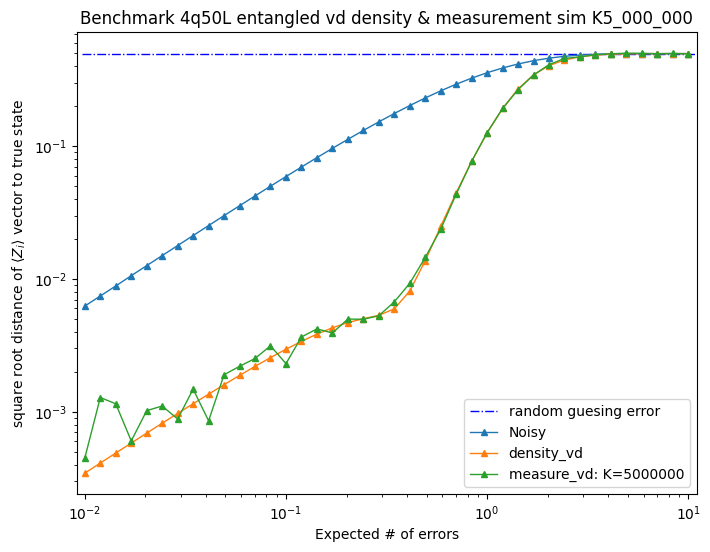

In [274]:
# Snippet that creates the plot from the benchmarking run that is still in memory
dist_random_state = vector_norm_distance(BMrun["true_Zi"], np.zeros(BMrun["N_qubits"]))

BMrun_fig = present_in_plot(BMrun["datapoints"], dist_random_state, BMrun["observable"], BMrun["datapoint_labels"], title=BMrun["benchmark_name"])

In [ ]:
# dictionary for shorthand names of certain plots
BM_runs = {

    "test":"Test_disjoint_BM_1q.pkl",
    "6q_entangled":"Benchmark_6q_entangled_random_circuit.pkl",
    "6q_non-entangled":"BM_6q_non_entangled.pkl"
}

In [ ]:
# function to create a plot from the pickle files 
def plot_BM_run(file_name):

    with open(file_name, 'rb') as f:
        BM_dict = pickle.load(f)
    
    dist_random_state = vector_norm_distance(BM_dict["true_Zi"], np.zeros(BM_dict["N_qubits"]))

    BM_fig = present_in_plot(BM_dict["datapoints"], dist_random_state, BM_dict["observable"], BM_dict["datapoint_labels"], title=BM_dict["benchmark_name"])  

    return BM_fig

In [ ]:
# Calling the plotting function based on the shorthands defined in the dictionary above
testrun = plot_BM_run(BM_runs['6q_entangled'])

testrun.show()

<h2>Appendix: Code snippets for timing the function implementations</h2>

In [ ]:
# Comparing the timed execution of 
# the denisty matrix and measurement based executors
test_circ_2, *args = create_randomised_benchmarking_circuit(6, 100, True, 2475257469243)
print(test_circ_2)
test_circ_2_noisy = rho.copy().with_noise(cirq.depolarize(p=0.01))

test_pBar = progressBar(1 + 1 + 100 + 100)

test_circ_Z = expectation_Zi(test_circ_2)
test_pBar.addTicks(1)
test_circ_2_noisy = test_circ_2.copy().with_noise(cirq.depolarize(p=0.1))

test_circ_Z_noisy = expectation_Zi(test_circ_2_noisy)
test_pBar.addTicks(1)
test_circ_2_vd_density_Z =  execute_with_vd(test_circ_2_noisy, density_simulation_executor, display_performance=True)
test_pBar.addTicks(100)
test_circ_2_vd_measurement_Z =  execute_with_vd(test_circ_2_noisy, measurement_simulation_executor, K=1_000_000, display_performance=True)
test_pBar.addTicks(100)
test_pBar.finished()

print(test_circ_Z)
print(test_circ_Z_noisy, vector_norm_distance(test_circ_Z, test_circ_Z_noisy))
print(test_circ_2_vd_density_Z, vector_norm_distance(test_circ_Z, test_circ_2_vd_density_Z))
print(test_circ_2_vd_measurement_Z, vector_norm_distance(test_circ_Z, test_circ_2_vd_measurement_Z))

In [ ]:
# Code snippet for benchmarking the execution time of the 
# density matrix executor implementation, as a function of 
# the number of qubits.
Zi_lis = []
times_lis = []
for n in range(1, 7):
    rho, *args = create_randomised_benchmarking_circuit(n, 100, True, 2475682256243)
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=0.01))
    T0 = time.time()
    Zi = execute_with_vd(noisy_rho, density_simulation_executor, display_performance=True)
    T1 = time.time()
    Zi_lis.append(Zi)
    times_lis.append(T1-T0)
    print(f"{n} qubits --> {T1-T0:10.5f} sec runtime")


In [ ]:
# Code snippet for benchmarking the execution time of the 
# measurement executor implementation, as a function of 
# the number of qubits, or the number of shots K.

Zi_lis_m = []
times_lis_m = []
for k in [10, 100, 500, 1000, 5000, 10000, 100_000, 1_000_000]:
    rho, *args = create_randomised_benchmarking_circuit(4, 100, True, 2475682256243)
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=0.01))
    T0 = time.time()
    Zi = execute_with_vd(noisy_rho, measurement_simulation_executor,K=k ,display_performance=True)
    T1 = time.time()
    Zi_lis_m.append(Zi)
    times_lis_m.append(T1-T0)
    # print(f"{n} qubits --> {T1-T0:10.5f} sec runtime")
    print(f"K = {k:10d} --> {T1-T0:10.5f} sec runtime")

# Quick note: @100 layers entangled, we have 3q->1.5s, 4q->1.3s!, 5q->2.8s, 6q->6.6s, 7q->160s, with K=100 
